In [2]:
import sys, os
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Ensure project root is in path
root = os.path.abspath("..")
if root not in sys.path:
    sys.path.append(root)

scripts_path = os.path.join(root, "scripts")
if scripts_path not in sys.path:
    sys.path.append(scripts_path)

# Project imports
from scripts.randomInstance import generate_instance, load_instance
from scripts.destruction_reconstruction import (
    run_batch_one_pass,
    default_parameters_for,
)
from evcs.model import build_base_model
from evcs.geom import build_arcs
from evcs.methods import (
    build_initial_solution_smart,
    build_initial_solution_weighted,
    local_search,
    evaluate_solution,
    compute_farther
)
from evcs.solve import solve_model
# === Deterministic vs W1 vs W2 (e.g., N = 60) ===

N = 20
SEED = 1
POLICIES = ("closest_only", "closest_priority", "system_optimum", "uniform")

# --------------------------
# 1) Deterministic
# --------------------------
df_det = run_batch_one_pass(
    Ns=(N,),
    seeds=(SEED,),
    policies=POLICIES,
    greedy_mode="deterministic",
    max_iter=30,
)

# Make nice deterministic main table
df_main = df_det.copy()
df_main.columns = pd.MultiIndex.from_tuples([
    ("ID", "N"), ("ID", "seed"), ("ID", "policy"),
    ("Exact", "Score exact"), ("Exact", "Time (s)"), ("Exact", "Gap (%)"),
    ("Heuristic", "Greedy score"), ("Heuristic", "LS score"),
    ("Heuristic", "LS time (s)"), ("Heuristic", "SA score"),
    ("Heuristic", "SA time (s)"),
])

# --------------------------
# 2) Weighted W1
# --------------------------
df_w1 = run_batch_one_pass(
    Ns=(N,),
    seeds=(SEED,),
    policies=POLICIES,
    greedy_mode="weighted_W1",
    max_iter=30,
)

# --------------------------
# 3) Weighted W2
# --------------------------
df_w2 = run_batch_one_pass(
    Ns=(N,),
    seeds=(SEED,),
    policies=POLICIES,
    greedy_mode="weighted_W2",
    max_iter=30,
)

# ---------------------------------------
# Rename columns for merging
# ---------------------------------------
det = df_det.rename(columns={
    "score_greedy":"det_greedy",
    "score_LS":"det_LS",
    "time_LS":"det_LS_time",
})[["N","seed","policy","score_exact","time_exact","det_greedy","det_LS","det_LS_time"]]

w1 = df_w1.rename(columns={
    "score_greedy":"W1_greedy",
    "score_LS":"W1_LS",
    "time_LS":"W1_LS_time",
})[["N","seed","policy","W1_greedy","W1_LS","W1_LS_time"]]

w2 = df_w2.rename(columns={
    "score_greedy":"W2_greedy",
    "score_LS":"W2_LS",
    "time_LS":"W2_LS_time",
})[["N","seed","policy","W2_greedy","W2_LS","W2_LS_time"]]

# ---------------------------------------
# Merge comparison table
# ---------------------------------------
df_compare = det.merge(w1, on=["N","seed","policy"]).merge(w2, on=["N","seed","policy"])

# ---------------------------------------
# Percent comparisons
# ---------------------------------------
df_compare["Det-Exact (%)"] = 100*(df_compare["det_LS"]/df_compare["score_exact"] - 1)
df_compare["W1-Exact (%)"]  = 100*(df_compare["W1_LS"]/df_compare["score_exact"] - 1)
df_compare["W2-Exact (%)"]  = 100*(df_compare["W2_LS"]/df_compare["score_exact"] - 1)

df_compare["W1-Det (%)"] = 100*(df_compare["W1_LS"] - df_compare["det_LS"])/df_compare["score_exact"]
df_compare["W2-Det (%)"] = 100*(df_compare["W2_LS"] - df_compare["det_LS"])/df_compare["score_exact"]
df_compare["W2-W1 (%)"]  = 100*(df_compare["W2_LS"] - df_compare["W1_LS"])/df_compare["score_exact"]

# ---------------------------------------
# Ordered columns
# ---------------------------------------
df_compare = df_compare[[
    "N","seed","policy",
    "score_exact","time_exact",
    "det_greedy","det_LS","det_LS_time",
    "W1_greedy","W1_LS","W1_LS_time",
    "W2_greedy","W2_LS","W2_LS_time",
    "Det-Exact (%)","W1-Exact (%)","W2-Exact (%)",
    "W1-Det (%)","W2-Det (%)","W2-W1 (%)",
]]

# Show
display(df_main)
display(df_compare)

# Save to Excel
Path("results").mkdir(exist_ok=True)
out_xlsx = "results/det_W1_W2_summary.xlsx"

df_main_flat = df_main.copy()
df_main_flat.columns = ["_".join(col) for col in df_main_flat.columns]

with pd.ExcelWriter(out_xlsx, engine="xlsxwriter") as writer:
    df_main_flat.to_excel(writer, sheet_name="Deterministic Main", index=False)
    df_compare.to_excel(writer, sheet_name="Det vs W1 vs W2", index=False)

print("✔ Saved to:", out_xlsx)



📌 N=20 | Policy=closest_only | greedy_mode=deterministic
  🔹 Exact solve ...
→ Added 'closest_only' constraints.
    ✅ Exact OPTIMAL: 60.000 (t=0.11s)
  🔹 Greedy initialization ...
→ Added 'closest_only' constraints.
     → Using SMART deterministic greedy
     Greedy score = 52.178
  🔹 Local Search ...

🔵 Local Search start (closest_only), initial obj=52.178
Iter 01: open/close 10->13 → 54.017
↪️ Switching to next neighborhood: MERGE
↪️ Switching to next neighborhood: SHIFT
🔚 No improvement in any neighborhood. Stopping at iter 16.
✅ Final objective (closest_only) = 54.017
     LS score = 54.017 (t=0.66s)
  🔹 Simulated Annealing ...

🔥 Simulated Annealing start (closest_only) | initial obj=54.017
✅ Final SA objective (closest_only) = 54.017
     SA score = 54.017 (t=0.21s)

📌 N=20 | Policy=closest_priority | greedy_mode=deterministic
  🔹 Exact solve ...
    ✅ Exact OPTIMAL: 59.992 (t=0.04s)
  🔹 Greedy initialization ...
     → Using SMART deterministic greedy
     Greedy score = 52.1

ID                              Exact                         Heuristic  \
    N seed            policy Score exact  Time (s)    Gap (%) Greedy score   
0  20    1      closest_only   60.000000  0.107286   9.971194    52.177969   
1  20    1  closest_priority   59.991538  0.040707   9.976297    52.170046   
2  20    1    system_optimum   57.471534  0.051725  10.652534    49.885673   
3  20    1           uniform   17.515237  0.023632   0.000000    17.515237   

                                                 
    LS score LS time (s)   SA score SA time (s)  
0  54.017284    0.657352  54.017284    0.213623  
1  54.006604    0.749571  55.330003    0.252824  
2  51.349360    0.763232  52.072178    0.259593  
3  17.515237    0.830941  17.515237    0.240256

,N,seed,policy,score_exact,time_exact,det_greedy,det_LS,det_LS_time,W1_greedy,W1_LS,W1_LS_time,W2_greedy,W2_LS,W2_LS_time,Det-Exact (%),W1-Exact (%),W2-Exact (%),W1-Det (%),W2-Det (%),W2-W1 (%)
0,20,1,closest_only,60.000000,0.107286,52.177969,54.017284,0.657352,35.858803,55.343494,0.736890,48.998031,55.343494,0.657075,-9.971194,-7.760843,-7.760843,2.210351,2.210351,0.000000
1,20,1,closest_priority,59.991538,0.040707,52.170046,54.006604,0.749571,43.310373,55.327781,0.781790,44.512985,53.539810,0.743070,-9.976297,-7.774025,-10.754398,2.202271,-0.778101,-2.980372
2,20,1,system_optimum,57.471534,0.051725,49.885673,51.349360,0.763232,41.863457,51.349360,0.820265,47.181522,52.072178,0.857263,-10.652534,-10.652534,-9.394835,0.000000,1.257698,1.257698
3,20,1,uniform,17.515237,0.023632,17.515237,17.515237,0.830941,45.062182,17.515237,1.019229,35.495992,17.515237,0.995318,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


✔ Saved to: results/det_W1_W2_summary.xlsx


In [3]:
# --- Minimal logger to capture LS path ---
class LSLogger:
    def __init__(self):
        self.records = []   # (iter, move_type, obj)

    def log_iter(self, it, move_type, obj_value, detail="", accepted=1, **kwargs):
        self.records.append((it, move_type, float(obj_value), int(accepted)))

    def finish_run(self, final_score):
        pass


→ Added 'closest_only' constraints.
load_solution=False and check results.termination_condition and
results.found_feasible_solution() before loading a solution.
→ Added 'closest_only' constraints.

🔵 Local Search start (closest_only), initial obj=168.521
Iter 01: open/close 32->51 → 172.880
Iter 02: open/close 41->42 → 173.208
Iter 03: open/close 20->41 → 175.805
↪️ Switching to next neighborhood: MERGE
↪️ Switching to next neighborhood: SHIFT
🔚 No improvement in any neighborhood. Stopping at iter 18.
✅ Final objective (closest_only) = 175.805
→ Added 'closest_only' constraints.
✅ Weighted greedy (W1) initialized with 6 stations.

🔵 Local Search start (closest_only), initial obj=150.503
Iter 01: open/close 5->4 → 151.556
Iter 02: open/close 45->58 → 160.508
Iter 03: open/close 19->36 → 164.222
Iter 04: open/close 4->16 → 164.835
Iter 05: open/close 47->37 → 165.061
Iter 06: open/close 16->34 → 168.001
Iter 07: open/close 30->16 → 168.474
Iter 08: open/close 16->9 → 169.646
Iter 09: ope

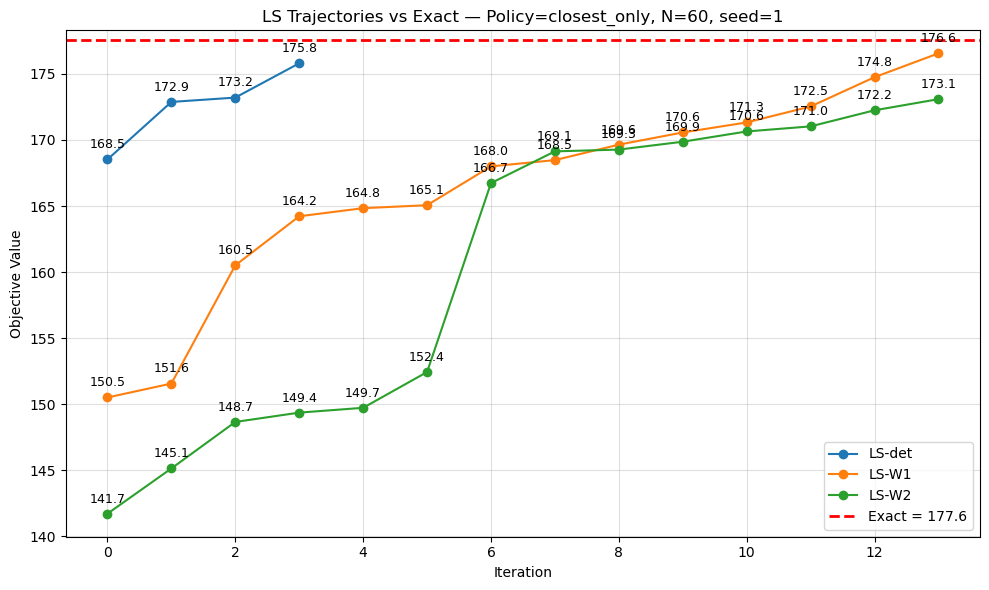

Final LS values: {'det': 175.80548539533265, 'W1': 176.55742407155597, 'W2': 173.08878528394234} | Exact=177.6


In [11]:
# === Combined LS trajectories (det, W1, W2) with numeric labels and exact line ===
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

from scripts.randomInstance import generate_instance, load_instance
from evcs.model import build_base_model
from evcs.geom import build_arcs
from evcs.methods import (
    build_initial_solution_smart,
    build_initial_solution_weighted,
    local_search,
    evaluate_solution,
    compute_farther
)
from scripts.destruction_reconstruction import default_parameters_for
from evcs.solve import solve_model

class LSLogger:
    def __init__(self):
        self.records = []
    def log_iter(self, it, move_type, obj_value, detail="", accepted=1, **kwargs):
        self.records.append((it, move_type, float(obj_value), int(accepted)))
    def finish_run(self, final_score): pass

# --- scenario ---
N, seed = 60, 1
POLICIES = ("closest_only", "closest_priority", "system_optimum", "uniform")

# instance
inst_path = Path("data/small") / f"inst_N{N}_seed{seed}.json"
inst = load_instance(inst_path) if inst_path.exists() else generate_instance(N=N, seed=seed)
coords_I, coords_J = inst["coords_I"], inst["coords_J"]
I_idx, J_idx = inst["I_idx"], inst["J_idx"]
demand_I = inst["demand_I"]
M, NN = len(I_idx), len(J_idx)
P, Q, D = default_parameters_for(N)

# arcs
distIJ, in_range, Ji, Ij = build_arcs(coords_I, coords_J, D=D, forbid_self=False, I_idx=I_idx, J_idx=J_idx)
farther_of = compute_farther(distIJ, in_range, Ij)

def ls_path_for_init(tag, weight_mode=None):
    m = build_base_model(M, NN, in_range, Ji, Ij, demand_I, Q, P, distIJ=distIJ, method_name=policy)
    if tag == "det":
        m = build_initial_solution_smart(m, distIJ, method_name=policy)
    elif tag == "W1":
        m = build_initial_solution_weighted(m, distIJ, demand_I, method_name=policy, weight_mode="W1")
    elif tag == "W2":
        m = build_initial_solution_weighted(m, distIJ, demand_I, method_name=policy, weight_mode=weight_mode or "W2")
    else:
        raise ValueError

    logger = LSLogger()
    m = local_search(m, distIJ, in_range, Ji, Ij, farther_of, method_name=policy,
                     max_iter=50, improvement_rule="first", try_order="random", logger=logger)
    df = pd.DataFrame(logger.records, columns=["iter","move","obj","accepted"])
    df = df[df["accepted"] == 1].sort_values("iter").reset_index(drop=True)
    return df

# exact
m_exact = build_base_model(M, NN, in_range, Ji, Ij, demand_I, Q, P, distIJ=distIJ, method_name=policy)
solve_model(m_exact, verbose=False, time_limit=20)
score_exact = evaluate_solution(m_exact, distIJ, demand_I, method_name=policy)["covered_demand"]

# run all
paths = {
    "det": ls_path_for_init("det"),
    "W1":  ls_path_for_init("W1"),
    "W2":  ls_path_for_init("W2"),  # or "W2a", "W2b", "W2c", "W2d" after you add them
}

# plot
plt.figure(figsize=(10,6))
for label, df in paths.items():
    plt.plot(df["iter"], df["obj"], marker="o", label=f"LS-{label}")
    # annotate each point with its value (1 decimal)
    for x, y in zip(df["iter"], df["obj"]):
        plt.annotate(f"{y:.1f}", (x, y), textcoords="offset points", xytext=(0,8), ha="center", fontsize=9)

plt.axhline(y=score_exact, linestyle="--", linewidth=2, color="red", label=f"Exact = {score_exact:.1f}")

plt.xlabel("Iteration")
plt.ylabel("Objective Value")
plt.title(f"LS Trajectories vs Exact — Policy={policy}, N={N}, seed={seed}")
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# also print final values
finals = {k: float(v["obj"].iloc[-1]) if len(v) else np.nan for k,v in paths.items()}
print("Final LS values:", finals, f"| Exact={score_exact:.1f}")


In [6]:
# === TABLE: Deterministic vs W1 vs W2 vs D&R ===
import sys, os, time
import pandas as pd
import numpy as np
from pathlib import Path

# ensure imports work from your project
root = os.path.abspath("..")
if root not in sys.path: sys.path.append(root)
scripts_path = os.path.join(root, "scripts")
if scripts_path not in sys.path: sys.path.append(scripts_path)

from scripts.destruction_reconstruction import run_batch_one_pass, default_parameters_for
from scripts.randomInstance import generate_instance, load_instance
from evcs.model import build_base_model
from evcs.geom import build_arcs
from evcs.methods import (
    build_initial_solution_smart,
    build_initial_solution_weighted,
    local_search,
    evaluate_solution,
    compute_farther,
    destruction_reconstruction,   # <- you added this in methods.py
)
from evcs.solve import solve_model

# ---------- config ----------
N = 20
SEED = 1
POLICIES = ("closest_only", "closest_priority", "system_optimum", "uniform")

# ---------- baseline batches ----------
df_det = run_batch_one_pass(
    Ns=(N,), seeds=(SEED,), policies=POLICIES,
    greedy_mode="deterministic", max_iter=50,
)
df_w1 = run_batch_one_pass(
    Ns=(N,), seeds=(SEED,), policies=POLICIES,
    greedy_mode="weighted_W1", max_iter=50,
)
df_w2 = run_batch_one_pass(
    Ns=(N,), seeds=(SEED,), policies=POLICIES,
    greedy_mode="weighted_W2", max_iter=50,
)

# ---------- D&R batch (one pass) ----------
# we’ll compute D&R per policy to add two columns: score_DR, time_DR
rows_dr = []
for policy in POLICIES:
    # load/generate the same instance used by run_batch_one_pass
    inst_path = Path("data/small") / f"inst_N{N}_seed{SEED}.json"
    inst = load_instance(inst_path) if inst_path.exists() else generate_instance(N=N, seed=SEED)

    coords_I, coords_J = inst["coords_I"], inst["coords_J"]
    I_idx, J_idx = inst["I_idx"], inst["J_idx"]
    demand_I = inst["demand_I"]

    P, Q, D = default_parameters_for(N)

    distIJ, in_range, Ji, Ij = build_arcs(
        coords_I, coords_J, D=D, forbid_self=False,
        I_idx=I_idx, J_idx=J_idx
    )
    farther_of = compute_farther(distIJ, in_range, Ij)

    # base model + greedy init (we’ll use the same reconstruction greedy: W2)
    m0 = build_base_model(len(I_idx), len(J_idx), in_range, Ji, Ij,
                          demand_I, Q, P, distIJ=distIJ, method_name=policy)
    m0 = build_initial_solution_weighted(m0, distIJ, demand_I,
                                         method_name=policy, weight_mode="W2")

    # quick LS before D&R (typical ILS flow)
    m0 = local_search(m0, distIJ, in_range, Ji, Ij, farther_of,
                      method_name=policy, max_iter=50)

    t0 = time.time()
    m_dr = destruction_reconstruction(
        m0, distIJ, demand_I,
        in_range, Ji, Ij, farther_of,
        method_name=policy,
        greedy_mode="weighted_W2",  # reconstruction greedy
        n_rounds=12,                # rounds of destroy + reconstruct + LS
        k_destroy=2,                # remove 2 stations per round (tunable)
        max_iter_LS=50,
        verbose=False,
    )
    t1 = time.time()

    score_dr = evaluate_solution(m_dr, distIJ, demand_I, method_name=policy)["covered_demand"]
    rows_dr.append(dict(N=N, seed=SEED, policy=policy, score_DR=score_dr, time_DR=t1 - t0))

df_dr = pd.DataFrame(rows_dr)

# ---------- rename & merge baseline tables ----------
det = df_det.rename(columns={
    "score_greedy":"det_greedy", "score_LS":"det_LS", "time_LS":"det_LS_time"
})[["N","seed","policy","score_exact","time_exact","det_greedy","det_LS","det_LS_time"]]

w1 = df_w1.rename(columns={
    "score_greedy":"W1_greedy","score_LS":"W1_LS","time_LS":"W1_LS_time"
})[["N","seed","policy","W1_greedy","W1_LS","W1_LS_time"]]

w2 = df_w2.rename(columns={
    "score_greedy":"W2_greedy","score_LS":"W2_LS","time_LS":"W2_LS_time"
})[["N","seed","policy","W2_greedy","W2_LS","W2_LS_time"]]

df_compare = det.merge(w1, on=["N","seed","policy"]) \
                .merge(w2, on=["N","seed","policy"]) \
                .merge(df_dr, on=["N","seed","policy"])

# ---------- percentage comparisons ----------
df_compare["Det-Exact (%)"] = 100*(df_compare["det_LS"]/df_compare["score_exact"] - 1)
df_compare["W1-Exact (%)"]  = 100*(df_compare["W1_LS"]/df_compare["score_exact"] - 1)
df_compare["W2-Exact (%)"]  = 100*(df_compare["W2_LS"]/df_compare["score_exact"] - 1)
df_compare["DR-Exact (%)"]  = 100*(df_compare["score_DR"]/df_compare["score_exact"] - 1)

df_compare["W1-Det (%)"] = 100*(df_compare["W1_LS"] - df_compare["det_LS"])/df_compare["score_exact"]
df_compare["W2-Det (%)"] = 100*(df_compare["W2_LS"] - df_compare["det_LS"])/df_compare["score_exact"]
df_compare["DR-Det (%)"] = 100*(df_compare["score_DR"] - df_compare["det_LS"])/df_compare["score_exact"]
df_compare["DR-W2 (%)"]  = 100*(df_compare["score_DR"] - df_compare["W2_LS"])/df_compare["score_exact"]

# ---------- order & display ----------
df_compare = df_compare[[
    "N","seed","policy",
    "score_exact","time_exact",
    "det_greedy","det_LS","det_LS_time",
    "W1_greedy","W1_LS","W1_LS_time",
    "W2_greedy","W2_LS","W2_LS_time",
    "score_DR","time_DR",
    "Det-Exact (%)","W1-Exact (%)","W2-Exact (%)","DR-Exact (%)",
    "W1-Det (%)","W2-Det (%)","DR-Det (%)","DR-W2 (%)",
]]

display(df_compare)

# ---------- save ----------
Path("results").mkdir(exist_ok=True)
out_xlsx = "results/det_W1_W2_DR_summary.xlsx"
with pd.ExcelWriter(out_xlsx, engine="xlsxwriter") as writer:
    df_compare.to_excel(writer, sheet_name="Det vs W1 vs W2 vs DR", index=False)
print("✔ Saved:", out_xlsx)



📌 N=20 | Policy=closest_only | greedy_mode=deterministic
  🔹 Exact solve ...
→ Added 'closest_only' constraints.
    ✅ Exact OPTIMAL: 60.000 (t=0.05s)
  🔹 Greedy initialization ...
→ Added 'closest_only' constraints.
     → Using SMART deterministic greedy
     Greedy score = 52.178
  🔹 Local Search ...

🔵 Local Search start (closest_only), initial obj=52.178
Iter 01: open/close 10->13 → 54.017
↪️ Switching to next neighborhood: MERGE
↪️ Switching to next neighborhood: SHIFT
🔚 No improvement in any neighborhood. Stopping at iter 16.
✅ Final objective (closest_only) = 54.017
     LS score = 54.017 (t=0.64s)
  🔹 Simulated Annealing ...

🔥 Simulated Annealing start (closest_only) | initial obj=54.017
Iter 110: SA improved → 55.343 (T=0.7738)
✅ Final SA objective (closest_only) = 55.343
     SA score = 55.343 (t=0.23s)

📌 N=20 | Policy=closest_priority | greedy_mode=deterministic
  🔹 Exact solve ...
    ✅ Exact OPTIMAL: 59.992 (t=0.04s)
  🔹 Greedy initialization ...
     → Using SMART det

,N,seed,policy,score_exact,time_exact,det_greedy,det_LS,det_LS_time,W1_greedy,W1_LS,...,score_DR,time_DR,Det-Exact (%),W1-Exact (%),W2-Exact (%),DR-Exact (%),W1-Det (%),W2-Det (%),DR-Det (%),DR-W2 (%)
0,20,1,closest_only,60.000000,0.054697,52.177969,54.017284,0.639670,45.062182,55.343494,...,55.343494,5.249336,-9.971194,-7.760843,-7.760843,-7.760843,2.210351,2.210351,2.210351,0.000000
1,20,1,closest_priority,59.991538,0.040678,52.170046,54.006604,0.783910,42.079330,54.006604,...,55.327781,6.235970,-9.976297,-9.976297,-9.976297,-7.774025,0.000000,0.000000,2.202271,2.202271
2,20,1,system_optimum,57.471534,0.051157,49.885673,51.349360,0.744952,30.340085,51.349360,...,52.072178,6.257970,-10.652534,-10.652534,-10.652534,-9.394835,0.000000,0.000000,1.257698,1.257698
3,20,1,uniform,17.515237,0.022442,17.515237,17.515237,0.816679,40.364951,17.515237,...,17.515237,6.610782,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


✔ Saved: results/det_W1_W2_DR_summary.xlsx


→ Added 'closest_only' constraints.
✅ Weighted greedy (W1) initialized with 7 stations.

🔵 Local Search start (closest_only), initial obj=163.388
Iter 01: open/close 21->0 → 165.493
Iter 02: open/close 0->2 → 167.410
Iter 03: open/close 2->4 → 168.237
Iter 04: open/close 4->9 → 168.675
Iter 05: open/close 41->0 → 192.503
Iter 06: open/close 0->2 → 195.389
Iter 07: open/close 2->4 → 196.215
Iter 08: open/close 4->38 → 196.669
Iter 09: open/close 44->2 → 196.746
Iter 10: open/close 2->4 → 197.389
Iter 11: open/close 38->17 → 198.231
Iter 12: open/close 4->2 → 199.135
Iter 13: open/close 2->19 → 199.568
Iter 14: open/close 19->52 → 199.778
Iter 15: open/close 46->0 → 200.788
Iter 16: open/close 0->1 → 209.211
Iter 17: open/close 1->23 → 216.550
Iter 18: open/close 9->48 → 216.567
Iter 19: open/close 23->77 → 218.215
Iter 20: open/close 57->6 → 221.117
Iter 21: open/close 17->0 → 222.208
Iter 22: open/close 48->9 → 222.352
Iter 23: open/close 62->7 → 231.738
Iter 24: open/close 76->74 → 23

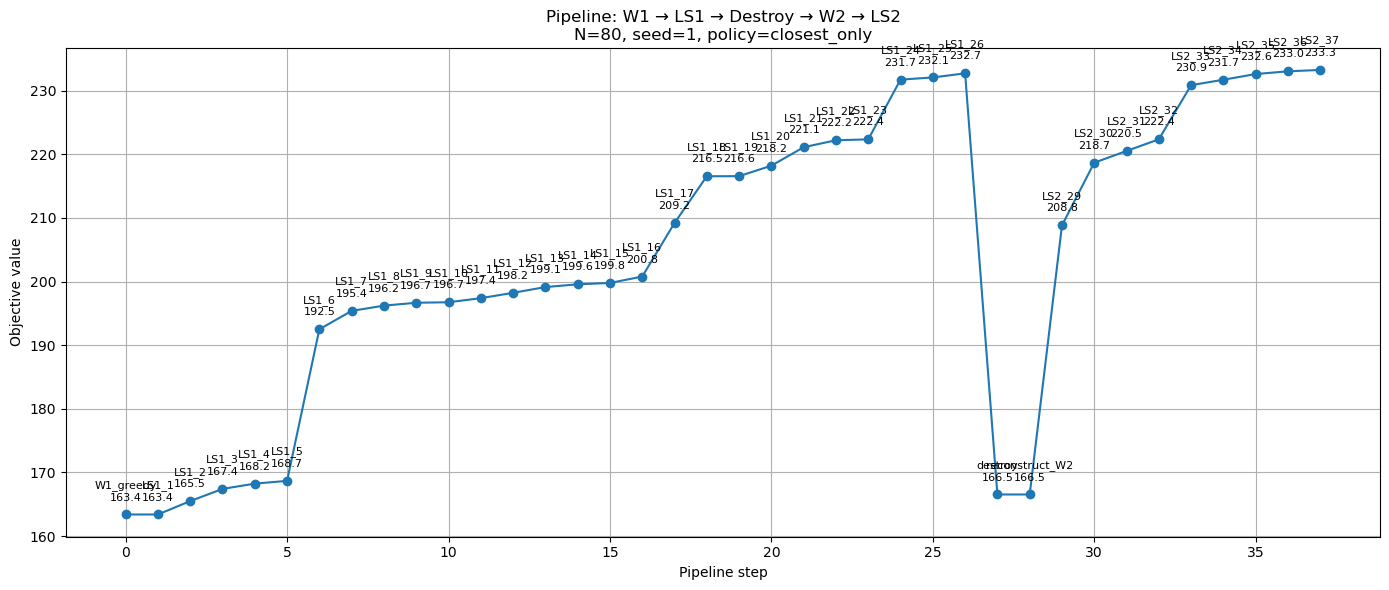

In [7]:
# === PIPELINE PLOT: W1 → LS1 → Destroy → W2 → LS2 ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


# === LS Logger (MUST MATCH local_search SIGNATURE) ===
class LSLogger:
    def __init__(self):
        self.records = []
    def log_iter(self, it, move_type, obj_value, detail="", accepted=1):
        self.records.append((it, move_type, float(obj_value), int(accepted)))
    def finish_run(self, final_score):
        pass


# === Load instance ===
N = 80
seed = 1
policy = "closest_only"

inst_path = Path("data/small") / f"inst_N{N}_seed{seed}.json"
inst = load_instance(inst_path) if inst_path.exists() else generate_instance(N=N, seed=seed)

coords_I, coords_J = inst["coords_I"], inst["coords_J"]
I_idx, J_idx = inst["I_idx"], inst["J_idx"]
demand_I = inst["demand_I"]

P, Q, D = default_parameters_for(N)

distIJ, in_range, Ji, Ij = build_arcs(
    coords_I, coords_J, D=D, forbid_self=False,
    I_idx=I_idx, J_idx=J_idx
)
farther_of = compute_farther(distIJ, in_range, Ij)


# ================================================================
#   PHASE A — W1 GREEDY INITIAL SOLUTION
# ================================================================
m0 = build_base_model(
    len(I_idx), len(J_idx),
    in_range, Ji, Ij,
    demand_I, Q, P,
    distIJ=distIJ,
    method_name=policy
)

m0 = build_initial_solution_weighted(
    m0, distIJ, demand_I,
    method_name=policy, weight_mode="W1"
)

score_W1 = evaluate_solution(m0, distIJ, demand_I, method_name=policy)["covered_demand"]


# ================================================================
#   PHASE B — LS1 from W1
# ================================================================
logger1 = LSLogger()
m1 = local_search(
    m0, distIJ, in_range, Ji, Ij, farther_of,
    method_name=policy,
    max_iter=50,
    logger=logger1
)

df_ls1 = pd.DataFrame(logger1.records, columns=["iter","move","obj","acc"])
df_ls1 = df_ls1[df_ls1.acc == 1].sort_values("iter").reset_index(drop=True)


# ================================================================
#   PHASE C — DESTROY
# ================================================================
k_destroy = max(1, P // 3)
print(f"Using k_destroy={k_destroy} out of P={P}")

m_destroy = m1.clone()
m_destroy = destroy_partial(m_destroy, k=k_destroy)

score_destroy = evaluate_solution(m_destroy, distIJ, demand_I, method_name=policy)["covered_demand"]


# ================================================================
#   PHASE D — RECONSTRUCT (W2) with YOUR NEW FUNCTION
# ================================================================
m_rebuild = reconstruction_greedy(
    m_destroy, distIJ, demand_I, D,
    method_name=policy,
    greedy_mode="weighted_W2"
)

score_rebuild = evaluate_solution(m_rebuild, distIJ, demand_I, method_name=policy)["covered_demand"]


# ================================================================
#   PHASE E — LS2 from W2 reconstruction
# ================================================================
logger2 = LSLogger()
m2 = local_search(
    m_rebuild, distIJ, in_range, Ji, Ij, farther_of,
    method_name=policy,
    max_iter=50,
    logger=logger2
)

df_ls2 = pd.DataFrame(logger2.records, columns=["iter","move","obj","acc"])
df_ls2 = df_ls2[df_ls2.acc == 1].sort_values("iter").reset_index(drop=True)


# ================================================================
#   BUILD PIPELINE TRAJECTORY
# ================================================================
xs, ys, labs = [], [], []

# --- W1 greedy ---
xs.append(0)
ys.append(score_W1)
labs.append("W1_greedy")

# --- LS1 path ---
for i, v in zip(df_ls1.iter + 1, df_ls1.obj):
    xs.append(i)
    ys.append(v)
    labs.append(f"LS1_{i}")

offset = xs[-1]

# --- Destroy ---
xs.append(offset + 1)
ys.append(score_destroy)
labs.append("destroy")

# --- Rebuild W2 ---
xs.append(offset + 2)
ys.append(score_rebuild)
labs.append("reconstruct_W2")

# --- LS2 path ---
for i, v in zip(df_ls2.iter + offset + 3, df_ls2.obj):
    xs.append(i)
    ys.append(v)
    labs.append(f"LS2_{i}")


# ================================================================
#   PLOT
# ================================================================
plt.figure(figsize=(14,6))
plt.plot(xs, ys, marker="o")

for x, y, lab in zip(xs, ys, labs):
    plt.annotate(f"{lab}\n{y:.1f}", (x, y),
                 xytext=(0,10), textcoords="offset points",
                 ha="center", fontsize=8)

plt.title(f"Pipeline: W1 → LS1 → Destroy → W2 → LS2\nN={N}, seed={seed}, policy={policy}")
plt.xlabel("Pipeline step")
plt.ylabel("Objective value")
plt.grid(True)
plt.tight_layout()
plt.show()
